In [144]:
import json
import math
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate

# plotly imports
import plotly.graph_objects as go

# yellowbrick imports
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

RANDOM_STATE = 43

# Load Data
Data is already scrubbed and available in json format

In [1]:
json_in = open("processed_data.json","r")
data = json.load(json_in)
json_in.close()

In [14]:
X_train, y_train, X_test, y_test = data.values()
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(824, 8) (824,) (206, 8) (206,)


# Polynomial transformations
Use PolynomialFeatures from sklearn.preprocessing to add higher degree features (degree=2, degree=3 and degree=4 ).

In [129]:
poly_data = []

poly_data.append([X_train, X_test]) #add the original data

for i in range(2, 5):
    pf =  PolynomialFeatures(degree=i, include_bias=False)
    pf.fit(X_train)
    poly_data.append([pf.transform(X_train), pf.transform(X_test)])

In [130]:
# check the number of features created for each degree of the polynomial
for i in range(len(poly_data)):
    print(f"Degree {i+1}, training data shape: {poly_data[i][0].shape}, test data shape: {poly_data[i][1].shape}")

Degree 1, training data shape: (824, 8), test data shape: (206, 8)
Degree 2, training data shape: (824, 44), test data shape: (206, 44)
Degree 3, training data shape: (824, 164), test data shape: (206, 164)
Degree 4, training data shape: (824, 494), test data shape: (206, 494)


# Ordinary Least Squares Regression

In [103]:
def display_scores(cv):
    """Display the scores of a cross validator """
    for score_type in ['train_score', 'test_score']:
        rmse_score = np.sqrt(-cv.get(score_type))
        print(f"{score_type}s:", rmse_score)
        print(f"{score_type}s mean:", rmse_score.mean())
        print(f"{score_type}s std. dev.:", rmse_score.std())

In [133]:
cvs=[]

for i in range(len(poly_data)):
    cvs.append(cross_validate(LinearRegression(), poly_data[i][0], y_train, scoring="neg_mean_squared_error", cv=5, 
                       return_train_score=True))
    
for i in range(len(cvs)):
    print(f"\nScores (RMSE) for a {i+1} degree polynomial:")
    display_scores(cvs[i])


Scores (RMSE) for a 1 degree polynomial:
train_scores: [10.46368059 10.54782681 10.18678671 10.1538928  10.23550986]
train_scores mean: 10.31753935327799
train_scores std. dev.: 0.1581106307277236
test_scores: [ 9.85383329  9.55413004 10.97478541 11.05990157 10.78794041]
test_scores mean: 10.44611814392313
test_scores std. dev.: 0.6195975716389082

Scores (RMSE) for a 2 degree polynomial:
train_scores: [7.08931883 7.16045372 7.07012336 7.04021271 6.97249558]
train_scores mean: 7.066520839081052
train_scores std. dev.: 0.06146377502156846
test_scores: [7.57629024 7.37495234 7.86230777 7.94946077 8.04117317]
test_scores mean: 7.760836857831734
test_scores std. dev.: 0.24796293534669916

Scores (RMSE) for a 3 degree polynomial:
train_scores: [4.22261364 4.34005066 4.26124728 4.21152256 4.17237456]
train_scores mean: 4.241561739963004
train_scores std. dev.: 0.05680816469394723
test_scores: [7.09098013 6.70071067 6.99485366 7.17172079 6.39712929]
test_scores mean: 6.871078907892818
test_s

<div class="alert alert-block alert-info">
As expected, the training scores decrease with the increase of the degree of the polynomial. Comparing the scores, it is clear that the 4th degree polynomial creates a model that overfits. However, the model corresponding to the 3rd degree polynomial seems not to overfit the data</div>

In [136]:
# create a Linear Regressor using degree 2 and 3 polynomial data
olr2 = LinearRegression()
olr2.fit(X_train_poly_2, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [137]:
olr3 = LinearRegression()
olr3.fit(X_train_poly_3, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Visualize Residual Plots 
We will create the residual plots for both 2nd and 3rd degree polynomial based models.

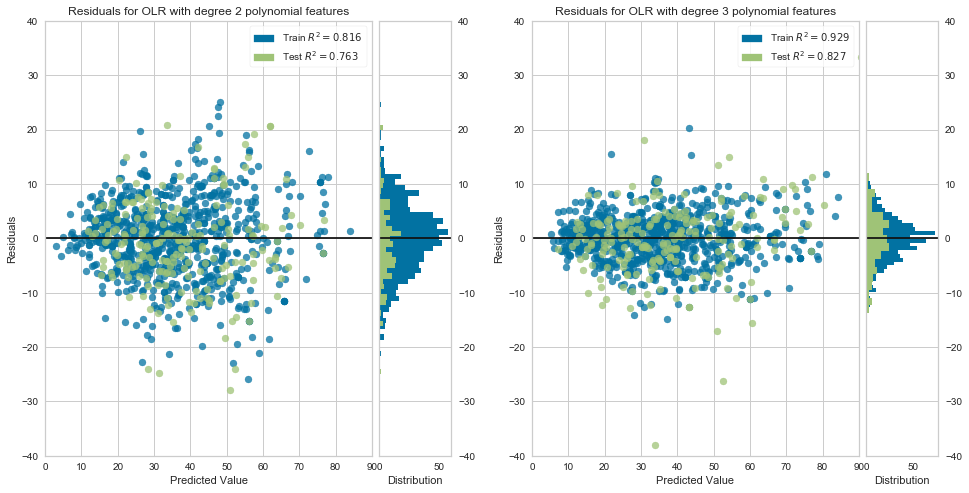

In [161]:
fig, axes = plt.subplots(1,2,figsize=[16,8])
visualgrid = [
    ResidualsPlot(olr2, ax=axes[0]),
    ResidualsPlot(olr3, ax=axes[1])]

for i in range(len(visualgrid)):
    vis = visualgrid[i]
    vis.fit(poly_data[i+1][0], y_train)
    vis.score(poly_data[i+1][1], y_test)
    vis.finalize()
    
visualgrid[0].ax.set_title('Residuals for OLR with degree 2 polynomial features')
visualgrid[0].ax.set_xlim(0,90)
visualgrid[0].ax.set_ylim(-40,40)

visualgrid[1].ax.set_title('Residuals for OLR with degree 3 polynomial features')
visualgrid[1].ax.set_xlim(0,90)
visualgrid[1].ax.set_ylim(-40,40)

plt.show()

## Visualize Prediction Error

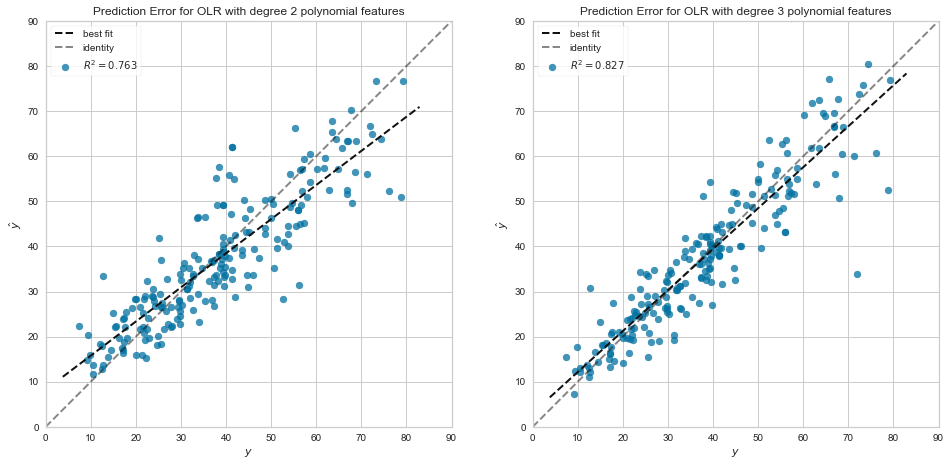

In [159]:
fig, axes = plt.subplots(1,2,figsize=[16,8])
visualgrid = [
    PredictionError(olr2, ax=axes[0]),
    PredictionError(olr3, ax=axes[1])]

for i in range(len(visualgrid)):
    vis = visualgrid[i]
    vis.fit(poly_data[i+1][0], y_train, )
    vis.score(poly_data[i+1][1], y_test)
    vis.finalize()

visualgrid[0].ax.set_title('Prediction Error for OLR with degree 2 polynomial features')
visualgrid[0].ax.set_xlim(0,90)
visualgrid[0].ax.set_ylim(0,90)

visualgrid[1].ax.set_title('Prediction Error for OLR with degree 3 polynomial features')
visualgrid[1].ax.set_xlim(0,90)
visualgrid[1].ax.set_ylim(0,90)
plt.show()

## Predictions

In [150]:
y_prediction_olr2 = olr2.predict(poly_data[1][1])
y_prediction_olr3 = olr3.predict(poly_data[2][1])

### RMSE

In [152]:
# RMSE
rmse_olr2 = math.sqrt(mean_squared_error(y_test, y_prediction_olr2))
rmse_olr3 = math.sqrt(mean_squared_error(y_test, y_prediction_olr3))
print('RMSE (OLR2): ', rmse_olr2, 'RMSE (OLR3):', rmse_olr3)

RMSE (OLR2):  8.127477709498548 RMSE (OLR3): 6.954262208870573


### Mean Absolute Error

In [153]:
mae_olr2 = mean_absolute_error(y_test, y_prediction_olr2)
mae_olr3 = mean_absolute_error(y_test, y_prediction_olr3)
print('MAE (CV): ', mae_olr2, 'MAE (OOB):', mae_olr3)

MAE (CV):  6.149199478102055 MAE (OOB): 4.844663173526565


### Predicted Values

In [154]:
predictions_df = pd.DataFrame(y_test)
predictions_df['Prediction(2rd degree poly)'] = y_prediction_olr2
predictions_df['Prediction(3rd degree poly)'] = y_prediction_olr3

In [155]:
pd.set_option('display.max_rows', 206)
print(predictions_df)

             0  Prediction(2rd degree poly)  Prediction(3rd degree poly)
0    20.966965                    21.677740                    19.784675
1    55.895819                    48.054938                    43.225904
2    17.436848                    18.792590                    17.607951
3    63.397318                    65.346001                    72.412546
4    44.611855                    33.591327                    35.244215
5    55.509713                    44.587532                    48.432617
6    38.630651                    35.236337                    33.440741
7    31.715896                    35.273635                    36.537741
8    51.331488                    39.700752                    44.105177
9    23.523542                    29.096645                    24.504421
10   43.565231                    39.223531                    44.835132
11   17.367900                    24.112864                    20.508656
12   17.540269                    22.046837        

***

# Ridge Regression

In [13]:
# Ridge regression
from sklearn.linear_model import Ridge

param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000]}]
grid_search_rr = GridSearchCV(Ridge(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_rr.fit(X_tr, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [14]:
print(grid_search_rr.best_params_)
print(np.sqrt(-grid_search_rr.best_score_))

{'alpha': 10}
0.4729131440307418


In [15]:
# Lasso regression 

from sklearn.linear_model import Lasso
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000]}]
grid_search_lr = GridSearchCV(Lasso(), param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search_lr.fit(X_tr, y_tr)

print(grid_search_lr.best_params_)
print(np.sqrt(-grid_search_lr.best_score_))   
    

{'alpha': 0.001}
0.6034455137633752


C:\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1439161680080474, tolerance: 0.05446780882136773
  positive)
C:\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.779868543927279, tolerance: 0.05578475060751559
  positive)
C:\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5447323748035018, tolerance: 0.05451739607211355
  positive)
C:\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07070707255938657, tolerance: 0.05

In [16]:
# Elastic Net regression

from sklearn.linear_model import ElasticNet

#elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
#elastic_net.fit(X, y)
#elastic_net.predict([[1.5]])


param_grid = [{'l1_ratio': [0,0.5,1]}]
grid_search_Enr = GridSearchCV(ElasticNet(alpha=0.1, random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
#grid_search_Enr = GridSearchCV(ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42), cv=3, scoring='neg_mean_squared_error')

grid_search_Enr.fit(X_tr, y_tr)

print(grid_search_Enr.best_params_)
print(np.sqrt(-grid_search_Enr.best_score_))


{'l1_ratio': 0}
0.4993522133372715


C:\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.5279214813654, tolerance: 0.05446780882136773
  positive)
C:\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.8571221107279, tolerance: 0.05578475060751559
  positive)
C:\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.19891067900775, tolerance: 0.05451739607211355
  positive)
C:\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.98475668111784, tolerance: 0.0823999

In [17]:
# Evaluating your best model on TESTING data
from sklearn.metrics import mean_squared_error

final_model = grid_search_lr.best_estimator_

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

0.44657795602626055
